In [1]:
import torch, math
torch.set_printoptions(precision=2, sci_mode=False, linewidth=200)
n_tokens = 80
memory = torch.triu(torch.ones(n_tokens, n_tokens), diagonal=0)
memory = memory * torch.randint_like(memory, 0, n_tokens)
memory = memory + memory.T - torch.diag(memory.diagonal())
memory = memory.long()
memory

/home/bary/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[ 1, 27,  8,  ..., 28, 73, 75],
        [27, 68,  4,  ..., 39,  9, 34],
        [ 8,  4, 51,  ..., 21, 16, 70],
        ...,
        [28, 39, 21,  ..., 78, 63, 68],
        [73,  9, 16,  ..., 63, 73, 68],
        [75, 34, 70,  ..., 68, 68, 11]])

In [222]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm


class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, dim_feedforward, dropout=0.0):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.dim_feedforward = dim_feedforward

        self.self_attn = nn.MultiheadAttention(d_model, n_head, batch_first=True, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, tgt, skip_feedforward=False, skip_self_attn=False, linear_mask=None, history=None, custom_attention=False, head_mask=None):
        hist = {}
        attn_heads = None
        if not skip_self_attn:
            # mask = torch.triu(torch.ones(tgt.shape[1], tgt.shape[1]), diagonal=1).bool().to(self.device)
            # tgt2, attn_heads = hist['self_attn_non_residual'] = self.self_attn(tgt, tgt, tgt, attn_mask=mask, average_attn_weights=False)
            tgt2 = hist['self_attn_non_residual'] = self.attn_forward(tgt, self.self_attn, custom_attention, hist, head_mask)
            tgt = hist['self_attn'] = tgt + tgt2
        tgt = hist['norm1'] = self.norm1(tgt)
        if self.dim_feedforward > 0 and not skip_feedforward:
            tgt2 = hist['linear1'] = nn.functional.relu(self.linear1(tgt))
            tgt2 = hist['linear1_dropout'] = self.dropout(tgt2)
            if linear_mask is not None:
                tgt2 = tgt2 * linear_mask
            tgt2 = hist['linear2_non_residual'] = self.linear2(tgt2)
            tgt = hist['linear2'] = tgt + tgt2
        tgt = hist['norm2'] = self.norm2(tgt)
        return tgt if history is None else hist[history], attn_heads
    
    def attn_forward(self, x, attn, custom_attention, history, head_mask=None):
        attn_mask = torch.tril(torch.ones(x.shape[1], x.shape[1]), diagonal=0).to(self.device)
        if not custom_attention:
            return attn(x, x, x, attn_mask=attn_mask)[0]

        batch_size = x.shape[0]
        x = x.transpose(0, 1)
        # this is just torch's attention but expanded so we can modify it
        proj = F.linear(x, attn.in_proj_weight, attn.in_proj_bias)
        proj = proj.unflatten(-1, (3, self.d_model)).unsqueeze(0).transpose(0, -2).squeeze(-2).contiguous()
        q, k, v = proj[0], proj[1], proj[2]
        q = q.unflatten(-1, (self.n_head, self.d_model // self.n_head)).permute(1, 2, 0, 3)
        k = k.unflatten(-1, (self.n_head, self.d_model // self.n_head)).permute(1, 2, 0, 3)
        v = v.unflatten(-1, (self.n_head, self.d_model // self.n_head)).permute(1, 2, 0, 3)
        
        history.update({
            'q': q,
            'k': k,
            'v': v
        })

        attn_mask = attn_mask.masked_fill(attn_mask == False, float('-inf'))
        
        attn_output = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1)) + attn_mask
        attn_output = F.softmax(attn_output, dim=-1)
        attn_output = torch.matmul(attn_output, v)
        attn_output = attn_output.permute(2, 0, 1, 3).contiguous()  # [seq_len, batch_size, n_head, d_model // n_head]
        # apply head mask
        if head_mask is not None:
            attn_output = attn_output * head_mask[None, None, :, None]
        
        history['attn_output'] = attn_output

        attn_output = attn_output.flatten(-2, -1)
        attn_output = F.linear(attn_output, attn.out_proj.weight, attn.out_proj.bias)
        return attn_output.transpose(0, 1)

class ToyTransformer(nn.Module):
    def __init__(self, n_layers, d_model, n_head, hidden_size, n_tokens, max_len, dropout=0.0):
        super().__init__()
        self.n_layers = n_layers
        self.d_model = d_model
        self.n_head = n_head
        self.hidden_size = hidden_size
        self.tokens = list(range(n_tokens))
        self.max_len = max_len

        self.embed = nn.Embedding(n_tokens, embedding_dim=d_model)

        self.layers = nn.ModuleList([
            DecoderLayer(d_model=d_model, n_head=n_head, dim_feedforward=hidden_size)
            for _ in range(n_layers)
        ])
        self.unembed = nn.Linear(d_model, n_tokens)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(
        self,
        x=None,
        inputs_embeds=None,
        skip_feedforward=False,
        skip_self_attn=False,
        return_before_embedding=False,
        linear_mask=None,
        history=None,
        return_attn_weights=False,
        custom_attention=False,
        head_mask=None,
        skip_layers=None):
        if x is None and inputs_embeds is None:
            raise ValueError('Either x or inputs_embeds must be specified.')
        
        if skip_layers is None:
            skip_layers = []
        if head_mask is not None:
            custom_attention = True
        if inputs_embeds is None:
            tgt = self.embed(x)
        else:
            tgt = inputs_embeds
        tgt = F.pad(tgt, (0, 0, 0, 1))  # [batch_size, seq_len + 1, d_model]
        history_layer = None
        if history is not None:
            history_layer = int(history.split('.')[0])
            history = history.split('.')[1]
        for i, layer in enumerate(self.layers):
            if i in skip_layers:
                continue
            tgt, attn_heads = layer(
                tgt,
                skip_feedforward=skip_feedforward,
                skip_self_attn=skip_self_attn,
                linear_mask=linear_mask,
                history=history if i == history_layer else None,
                custom_attention=custom_attention,
                head_mask=head_mask)
            if i == history_layer:
                return tgt
        if return_before_embedding:
            return tgt
        x = self.unembed(tgt)
        if return_attn_weights:
            return x, attn_heads
        return x

    def train(self, lr=1e-3, batch_size=128, n_epochs=1000, eval_every=1000):
        optimizer = optim.AdamW(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        total_loss = 0
        for i in tqdm(range(n_epochs)):
            batch = self.generate_data(batch_size)
            optimizer.zero_grad()
            input = batch[:, :-1]
            output = self(input)
            loss = criterion(output.reshape(-1, len(self.tokens)), batch.reshape(-1))
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

            if (i + 1) % eval_every == 0:
                print('loss: ', total_loss / eval_every)
                total_loss = 0
                samples = 1000
                data = self.generate_data(samples)
                output = (self(data[:,:-1])[:,-1,:].argmax(dim=-1))
                print('Accuracy: ', output.eq(data[:,-1]).sum().item() / samples)

    def generate_data(self, batch_size):
        random_indices = torch.randint(0, n_tokens, (batch_size, 2))  # [batch_size, 2]
        next_tokens = memory[random_indices[:, 0], random_indices[:, 1]].unsqueeze(1)  # [batch_size, 1]
        tensor = torch.cat([random_indices, next_tokens], dim=1)
        return tensor.to(self.device)



In [223]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [224]:
model = ToyTransformer(n_layers=6, d_model=16, n_head=4, hidden_size=64, n_tokens=n_tokens, max_len=3, dropout=0.0).to(device)

In [225]:
model.train(lr=1e-3, n_epochs=6000, batch_size=300)
samples = 1000
data = model.generate_data(samples)
output = (model(data[:,:-1])[:,-1,:].argmax(dim=-1))
print('Accuracy: ', output.eq(data[:,-1]).sum().item() / samples)

  0%|          | 1/6000 [00:00<13:51,  7.22it/s]

 17%|█▋        | 1002/6000 [00:55<04:33, 18.28it/s]

loss:  1.701658380806446
Accuracy:  0.261


 33%|███▎      | 2002/6000 [01:51<03:23, 19.61it/s]

loss:  0.762347317814827
Accuracy:  0.58


 50%|█████     | 3005/6000 [02:38<01:44, 28.78it/s]

loss:  0.3836884843111038
Accuracy:  0.81


 67%|██████▋   | 3999/6000 [03:19<00:58, 33.94it/s]

loss:  0.18401972876489162
Accuracy:  0.911


 83%|████████▎ | 5003/6000 [03:55<00:34, 28.85it/s]

loss:  0.09980261391028762
Accuracy:  0.949


100%|██████████| 6000/6000 [04:33<00:00, 21.97it/s]


loss:  0.05114377006702125
Accuracy:  1.0
Accuracy:  1.0


In [226]:
torch.save(model.state_dict(), '6_layer.pt')

In [227]:
output = (model(data[:,:-1], skip_layers=[0])[:,-1,:].argmax(dim=-1))
print('Accuracy without first layer: ', output.eq(data[:,-1]).sum().item() / samples)
output = (model(data[:,:-1], skip_layers=[1])[:,-1,:].argmax(dim=-1))
print('Accuracy without second layer: ', output.eq(data[:,-1]).sum().item() / samples)
output = (model(data[:,:-1], skip_layers=[2])[:,-1,:].argmax(dim=-1))
print('Accuracy without third layer: ', output.eq(data[:,-1]).sum().item() / samples)
output = (model(data[:,:-1], skip_layers=[3])[:,-1,:].argmax(dim=-1))
print('Accuracy without fourth layer: ', output.eq(data[:,-1]).sum().item() / samples)
output = (model(data[:,:-1], skip_layers=[4])[:,-1,:].argmax(dim=-1))
print('Accuracy without fifth layer: ', output.eq(data[:,-1]).sum().item() / samples)
output = (model(data[:,:-1], skip_layers=[5])[:,-1,:].argmax(dim=-1))
print('Accuracy without sixth layer: ', output.eq(data[:,-1]).sum().item() / samples)

Accuracy without first layer:  0.006
Accuracy without second layer:  0.041
Accuracy without third layer:  0.04
Accuracy without fourth layer:  0.048
Accuracy without fifth layer:  0.044
Accuracy without sixth layer:  0.072


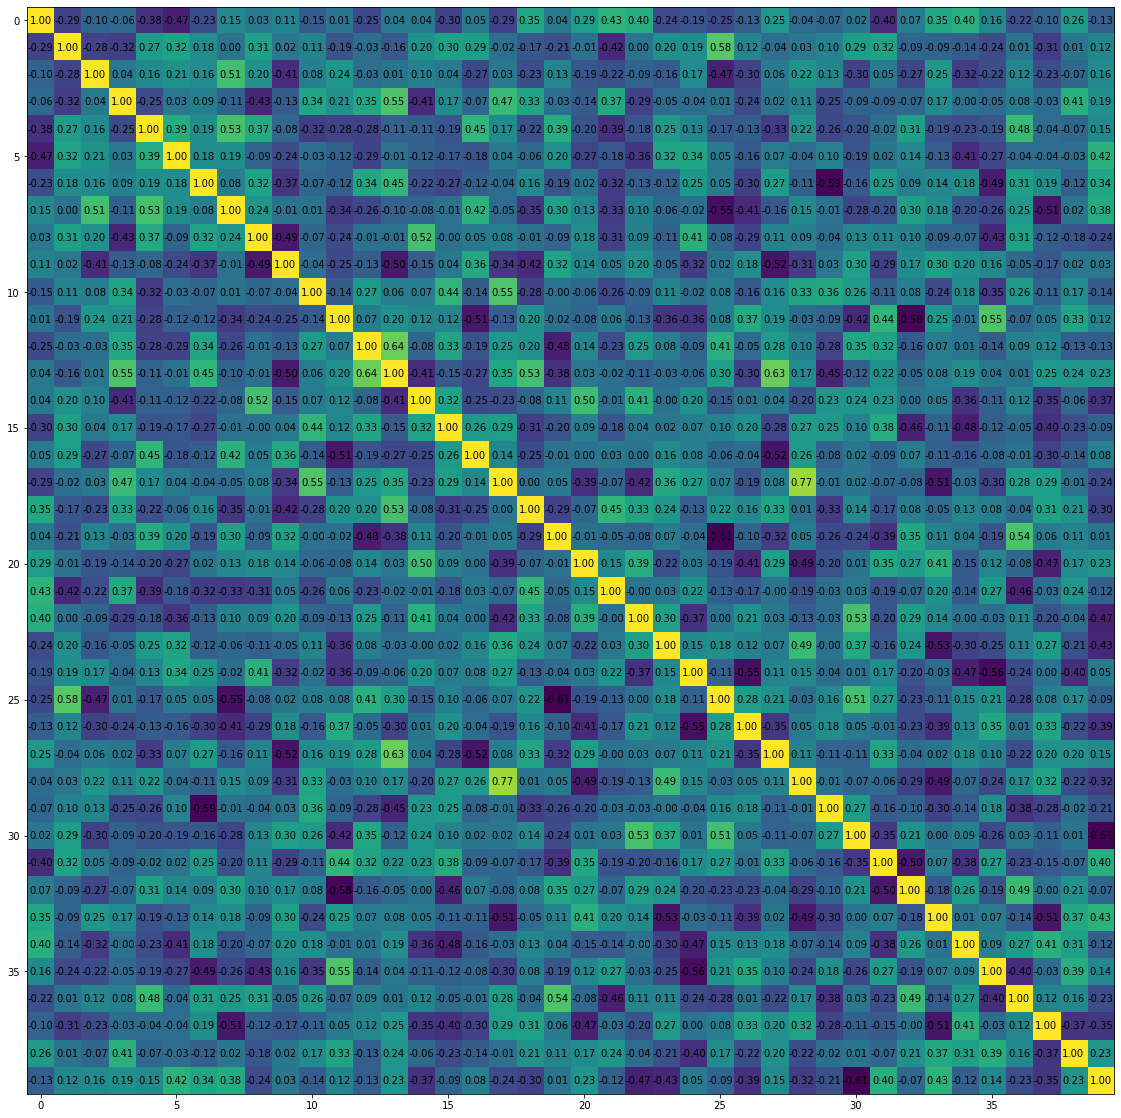

In [50]:
first_k_tokens = 40
tokens = torch.arange(first_k_tokens)
embeddings = model.embed(tokens).detach().cpu()
embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
cos_sim = torch.matmul(embeddings, embeddings.T)
plt.figure(figsize=(20,20))
plt.imshow(cos_sim)
for i in range(first_k_tokens):
    for j in range(first_k_tokens):
        plt.text(i, j, f'{cos_sim[i,j]:.2f}', ha='center', va='center', color='black')

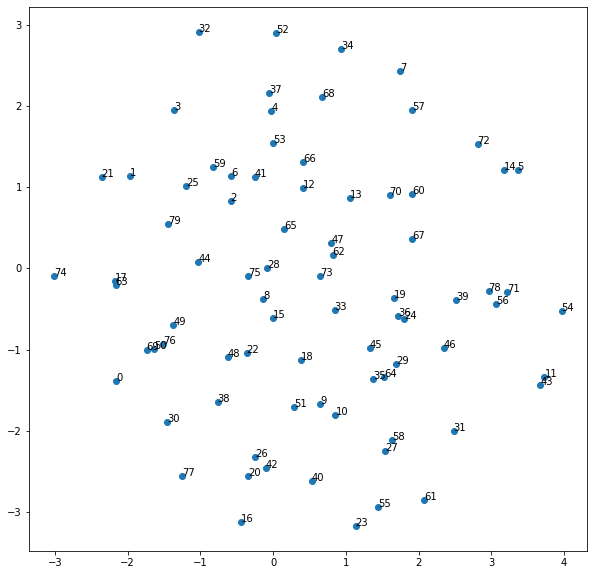

In [167]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tokens = torch.arange(n_tokens)
embeddings = model.embed(tokens).detach().cpu()
tsne_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1])
for i in range(n_tokens):
    plt.text(tsne_embeddings[i,0], tsne_embeddings[i,1], str(i), color='black')

In [228]:

for prompt in [[0,1], [0,2], [0,3], [0,4], [1,17]]:
    print(f'Prompt: {prompt}')
    x, y = prompt
    for i in range(len(model.layers)):
        layer = model(torch.tensor([prompt]), history=f'{i}.norm1')[:,-1,:].detach().cpu()

        components = torch.zeros(n_tokens, 3, model.d_model)
        components[:,0,:] = model.embed(torch.arange(n_tokens))
        components_attn = model(inputs_embeds=components, history=f'{i}.self_attn')[:,-1,:].detach().cpu()

        cos_sim = torch.cosine_similarity(layer[0], model.layers[i].norm1(components_attn[x] + components_attn[y]), dim=-1)
        actual_class = memory[x, y]
        layer = model.layers[i].norm2(layer + model.layers[i].linear2(F.relu(model.layers[i].linear1(layer))))
        cos_sim2 = torch.cosine_similarity(layer[0], model.layers[i].norm2(model.layers[i].norm1(components_attn[x] + components_attn[y])), dim=-1)
        layer = model.unembed(layer)
        residual_stream_topk = layer[0].softmax(dim=-1).topk(5)
        indices = residual_stream_topk.indices
        values = residual_stream_topk.values
        predicted = ' '.join([f'{a}({b.item():.2f})' for a, b in zip(indices, values)])
        print(f'Layer {i} attn similarity: {cos_sim:.2f} ff similarity: {cos_sim2:.2f} predicted {predicted} (actual class: {actual_class})')


Prompt: [0, 1]
Layer 0 attn similarity: 0.95 ff similarity: 0.90 predicted 58(0.24) 64(0.22) 57(0.13) 65(0.07) 63(0.06) (actual class: 27)
Layer 1 attn similarity: 0.64 ff similarity: 0.49 predicted 57(0.37) 29(0.19) 65(0.15) 64(0.08) 50(0.03) (actual class: 27)
Layer 2 attn similarity: 0.67 ff similarity: 0.63 predicted 57(0.29) 29(0.17) 64(0.16) 58(0.08) 50(0.04) (actual class: 27)
Layer 3 attn similarity: 0.77 ff similarity: 0.66 predicted 64(0.34) 58(0.23) 3(0.09) 29(0.09) 50(0.07) (actual class: 27)
Layer 4 attn similarity: 0.42 ff similarity: 0.37 predicted 55(0.22) 58(0.10) 20(0.09) 44(0.08) 64(0.06) (actual class: 27)
Layer 5 attn similarity: 0.35 ff similarity: -0.16 predicted 27(0.99) 53(0.00) 15(0.00) 18(0.00) 7(0.00) (actual class: 27)
Prompt: [0, 2]
Layer 0 attn similarity: 1.00 ff similarity: 0.95 predicted 1(0.21) 57(0.17) 20(0.16) 47(0.09) 2(0.07) (actual class: 8)
Layer 1 attn similarity: 0.97 ff similarity: 0.90 predicted 9(0.24) 78(0.10) 57(0.09) 1(0.06) 20(0.06) (ac

In [229]:

for prompt in [[0,1], [0,2], [0,3], [0,4], [1,17]]:
    layer_activations = []
    print(f'Prompt: {prompt}')
    x, y = prompt
    for i in range(len(model.layers)):
        layer = model(torch.tensor([prompt]), history=f'{i}.norm1')[:,-1,:].detach().cpu()

        layer_activations.append(layer[0])

    for i in range(len(layer_activations) - 1):
        cos_sim = torch.cosine_similarity(layer_activations[i], layer_activations[i+1], dim=-1)
        print(f'Layer {i} similarity to layer {i+1}: {cos_sim:.2f}')
    
        

Prompt: [0, 1]
Layer 0 similarity to layer 1: 0.95
Layer 1 similarity to layer 2: 0.92
Layer 2 similarity to layer 3: 0.90
Layer 3 similarity to layer 4: 0.90
Layer 4 similarity to layer 5: 0.74
Prompt: [0, 2]
Layer 0 similarity to layer 1: 0.94
Layer 1 similarity to layer 2: 0.86
Layer 2 similarity to layer 3: 0.87
Layer 3 similarity to layer 4: 0.85
Layer 4 similarity to layer 5: 0.67
Prompt: [0, 3]
Layer 0 similarity to layer 1: 0.93
Layer 1 similarity to layer 2: 0.79
Layer 2 similarity to layer 3: 0.95
Layer 3 similarity to layer 4: 0.85
Layer 4 similarity to layer 5: 0.86
Prompt: [0, 4]
Layer 0 similarity to layer 1: 0.86
Layer 1 similarity to layer 2: 0.85
Layer 2 similarity to layer 3: 0.94
Layer 3 similarity to layer 4: 0.84
Layer 4 similarity to layer 5: 0.74
Prompt: [1, 17]
Layer 0 similarity to layer 1: 0.82
Layer 1 similarity to layer 2: 0.90
Layer 2 similarity to layer 3: 0.74
Layer 3 similarity to layer 4: 0.81
Layer 4 similarity to layer 5: 0.76


In [230]:

for prompt in [[0,1], [0,2], [0,3], [0,4], [1,17]]:
    layer_activations = []
    print(f'Prompt: {prompt}')
    x, y = prompt
    for i in range(len(model.layers)):
        layer = model(torch.tensor([prompt]), history=f'{i}.norm1')[:,-1,:].detach().cpu()

        layer_activations.append(layer[0])

    for i in range(len(layer_activations) - 1):
        cos_sim = torch.cosine_similarity(layer_activations[0], layer_activations[i+1], dim=-1)
        print(f'Layer 0 similarity to layer {i+1}: {cos_sim:.2f}')
    
        

Prompt: [0, 1]
Layer 0 similarity to layer 1: 0.95
Layer 0 similarity to layer 2: 0.83
Layer 0 similarity to layer 3: 0.72
Layer 0 similarity to layer 4: 0.74
Layer 0 similarity to layer 5: 0.42
Prompt: [0, 2]
Layer 0 similarity to layer 1: 0.94
Layer 0 similarity to layer 2: 0.77
Layer 0 similarity to layer 3: 0.75
Layer 0 similarity to layer 4: 0.59
Layer 0 similarity to layer 5: 0.44
Prompt: [0, 3]
Layer 0 similarity to layer 1: 0.93
Layer 0 similarity to layer 2: 0.69
Layer 0 similarity to layer 3: 0.58
Layer 0 similarity to layer 4: 0.59
Layer 0 similarity to layer 5: 0.44
Prompt: [0, 4]
Layer 0 similarity to layer 1: 0.86
Layer 0 similarity to layer 2: 0.64
Layer 0 similarity to layer 3: 0.64
Layer 0 similarity to layer 4: 0.57
Layer 0 similarity to layer 5: 0.52
Prompt: [1, 17]
Layer 0 similarity to layer 1: 0.82
Layer 0 similarity to layer 2: 0.80
Layer 0 similarity to layer 3: 0.86
Layer 0 similarity to layer 4: 0.66
Layer 0 similarity to layer 5: 0.59


In [245]:
# both entires are 24
prompt1 = [1, 5]
prompt2 = [4, 7]
for i in range(len(model.layers)):
    layer = model(torch.tensor([prompt1, prompt2]), history=f'{i}.linear2_non_residual')[:,-1,:].detach().cpu()
    print('cosine similarity', torch.cosine_similarity(layer[0], layer[1], dim=-1))

cosine similarity tensor(-0.33)
cosine similarity tensor(0.57)
cosine similarity tensor(-0.16)
cosine similarity tensor(-0.30)
cosine similarity tensor(-0.01)
cosine similarity tensor(-0.35)


In [303]:
# both are 8
prompt1 = [9, 10]
prompt2 = [0, 2]
for i in range(len(model.layers)):
    layer = model(torch.tensor([prompt1, prompt2]), history=f'{i}.linear2_non_residual')[:,-1,:].detach().cpu()
    print('cosine similarity', torch.cosine_similarity(layer[0], layer[1], dim=-1))

cosine similarity tensor(0.11)
cosine similarity tensor(0.15)
cosine similarity tensor(0.30)
cosine similarity tensor(-0.08)
cosine similarity tensor(0.15)
cosine similarity tensor(0.12)


In [304]:
# both entires are 24
prompt1 = [1, 5]
prompt2 = [4, 7]
for i in range(len(model.layers)):
    layer = model(torch.tensor([prompt1, prompt2]), history=f'{i}.linear2')[:,-1,:].detach().cpu()
    print('cosine similarity', torch.cosine_similarity(layer[0], layer[1], dim=-1))

cosine similarity tensor(-0.35)
cosine similarity tensor(-0.39)
cosine similarity tensor(-0.70)
cosine similarity tensor(-0.28)
cosine similarity tensor(-0.18)
cosine similarity tensor(0.44)


In [305]:
# both are 8
prompt1 = [9, 10]
prompt2 = [0, 2]
for i in range(len(model.layers)):
    layer = model(torch.tensor([prompt1, prompt2]), history=f'{i}.linear2')[:,-1,:].detach().cpu()
    print('cosine similarity', torch.cosine_similarity(layer[0], layer[1], dim=-1))

cosine similarity tensor(-0.29)
cosine similarity tensor(-0.25)
cosine similarity tensor(0.02)
cosine similarity tensor(-0.02)
cosine similarity tensor(-0.21)
cosine similarity tensor(0.42)


In [187]:
prompt = [0, 4]
x, y = prompt
for layer_i in range(len(model.layers)):
    layer = model(torch.tensor([prompt]), history=f'{layer_i}.norm1')[:,-1,:].detach().cpu()
    cos_sim = torch.zeros(n_tokens, n_tokens)
    components = torch.zeros(n_tokens, 3, model.d_model)
    components[:,0,:] = model.embed(torch.arange(n_tokens))
    components_attn = model(inputs_embeds=components, history=f'{i}.self_attn')[:,-1,:].detach().cpu()
    print(components_attn.shape)
    for i in range(n_tokens):
        for j in range(n_tokens):
            cos_sim[i,j] = torch.cosine_similarity(layer[0], model.layers[layer_i].norm1(components_attn[i] + components_attn[j]), dim=-1)

    print([(x // n_tokens, x % n_tokens) for x in cos_sim.reshape(-1).topk(10).indices.tolist()])

torch.Size([80, 16])
[(0, 4), (4, 0), (0, 1), (1, 0), (6, 0), (0, 6), (6, 4), (4, 6), (6, 1), (1, 6)]
torch.Size([80, 80])


RuntimeError: Given normalized_shape=[16], expected input with shape [*, 16], but got input of size[80]